**Table of contents**<a id='toc0_'></a>    
- [<b> Import Libraries </b>](#toc1_)    
    - [Load configuration file](#toc1_1_1_)    
    - [Load Train and Valid set](#toc1_1_2_)    
- [<b>Fitting Model</b>](#toc2_)    
    - [Baseline Mean Model](#toc2_1_1_)    
    - [Weight Model](#toc2_1_2_)    
- [<B>Baseline ML Model</b>](#toc3_)    
  - [Create Training Log](#toc3_1_)    
  - [Create Multiple Model Objects](#toc3_2_)    
  - [Create Fitting Function](#toc3_3_)    
  - [Training Model](#toc3_4_)    
  - [Create function to save production model](#toc3_5_)    
  - [Save Best model and Update Training Logs](#toc3_6_)    
  - [Baseline Model Overview](#toc3_7_)    
  - [Top Baseline Model](#toc3_8_)    
- [<b>Hyperparams</b>](#toc4_)    
  - [Gradient Boosting Oversampling](#toc4_1_)    
    - [Oversampling](#toc4_1_1_)    
    - [Smote](#toc4_1_2_)    
    - [ROC Curve Gradient Boosting on SMOTE and Oversampling](#toc4_1_3_)    
  - [Random Forest](#toc4_2_)    
    - [Smote](#toc4_2_1_)    
  - [XGBOOST Classifier](#toc4_3_)    
    - [Smote](#toc4_3_1_)    
    - [Oversampling](#toc4_3_2_)    
  - [Decision Tree](#toc4_4_)    
    - [Smote](#toc4_4_1_)    
  - [ADABOOST](#toc4_5_)    
    - [Smote](#toc4_5_1_)    
  - [<b>ROC Plot (Auc Score)</b>](#toc4_6_)    
- [<b> Hyperparameter Tuning</b>](#toc5_)    
  - [Create Param Distribution](#toc5_1_)    
    - [run debugging](#toc5_1_1_)    
  - [Create Training Function based on Validation](#toc5_2_)    
  - [Training model and update Training Logs](#toc5_3_)    
  - [Best Model Overview](#toc5_4_)    
- [<b>Test Data</b>](#toc6_)    
  - [Create ROC Curve toward Test Set](#toc6_1_)    
  - [Create Function to Eval Test Data](#toc6_2_)    
  - [Training Dataset and Update Training Logs](#toc6_3_)    
  - [Check Best Model](#toc6_4_)    
  - [Save Production Model](#toc6_5_)    
- [<b>Show Best Final Model</b>](#toc7_)    
- [<b> Check Production Model</b>](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[<b> Import Libraries </b>](#toc0_)

In [1]:
import src.util as util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import hashlib
import json

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

### <a id='toc1_1_1_'></a>[Load configuration file](#toc0_)

In [2]:
config_data = util.load_config()

### <a id='toc1_1_2_'></a>[Load Train and Valid set](#toc0_)

In [3]:
## Load function to call dataset
def load_train_clean(params: dict) -> pd.DataFrame:
    x_train = util.pickle_load(params["train_set_clean"][0])
    y_train = util.pickle_load(params["train_set_clean"][1])

    return x_train, y_train

def load_valid_clean(params:dict) -> pd.DataFrame:
    x_valid = util.pickle_load(params["valid_set_clean"][0])
    y_valid = util.pickle_load(params["valid_set_clean"][1])

    return x_valid, y_valid

def load_test_clean(params: dict) -> pd.DataFrame:
    x_test = util.pickle_load(params["test_set_clean"][0])
    y_test = util.pickle_load(params["test_set_clean"][1])

    return x_test, y_test

In [4]:
x_train, y_train = load_train_clean(config_data)
x_valid, y_valid = load_valid_clean(config_data)
x_test, y_test = load_test_clean(config_data)

# <a id='toc2_'></a>[<b>Fitting Model</b>](#toc0_)
------

### <a id='toc2_1_1_'></a>[Baseline Mean Model](#toc0_)

In [5]:
def Baseline_model():
    dummy_clf = DummyClassifier(strategy='stratified')

    dummy_clf.fit(x_train["nonbalance"], y_train["nonbalance"])

    y_pred = dummy_clf.predict(x_train["nonbalance"])

    report = classification_report(y_true = y_train["nonbalance"],
                                    y_pred = y_pred,
                                    output_dict = True)
    report = pd.DataFrame(report)
    return report

In [6]:
## Show the baseline model of raw dataset
report = Baseline_model()

report["macro avg"]["f1-score"]

0.47746134695606623

### <a id='toc2_1_2_'></a>[Weight Model](#toc0_)

In [7]:
def add_weight():
    sklearn_weight = compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(y_train["nonbalance"]), 
                                            y = y_train["nonbalance"])
    sklearn_weight = dict(zip(np.unique(y_train["nonbalance"]), sklearn_weight))

    util.pickle_dump(sklearn_weight, config_data['model_params_path'][0])

    return sklearn_weight

In [8]:
sklearn_weight = add_weight()
sklearn_weight

{0: 0.6644518272425249, 1: 2.0202020202020203}

# <a id='toc3_'></a>[<B>Baseline ML Model</b>](#toc0_)
----

## <a id='toc3_1_'></a>[Create Training Log](#toc0_)

In [9]:
## Create Training log function
def training_log_template() -> dict:
    # Debug message
    util.print_debug("creating training log template.")

    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "recall_score" : [],
        "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [10]:
## Create training log updater
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log


## <a id='toc3_2_'></a>[Create Multiple Model Objects](#toc0_)
---------------

In [11]:
## Create model object of machine learning model
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    # baseline_knn = KNeighborsClassifier()
    baseline_dt = DecisionTreeClassifier()
    baseline_logreg = LogisticRegression()
    baseline_svm = SVC()
    baseline_rforest = RandomForestClassifier()
    baseline_ada = AdaBoostClassifier()
    baseline_grad = GradientBoostingClassifier()
    baseline_xgb = XGBClassifier()
    baseline_qda = QuadraticDiscriminantAnalysis()
    baseline_gnb = GaussianNB()

    # Create list of model
    list_of_model = [
        # { "model_name": baseline_knn.__class__.__name__, "model_object": baseline_knn, "model_uid": ""},
        { "model_name": baseline_dt.__class__.__name__, "model_object": baseline_dt, "model_uid": ""},
        { "model_name": baseline_logreg.__class__.__name__, "model_object": baseline_logreg, "model_uid": ""},
        { "model_name": baseline_svm.__class__.__name__, "model_object": baseline_svm, "model_uid": ""},
        { "model_name": baseline_rforest.__class__.__name__, "model_object": baseline_rforest, "model_uid": ""},
        { "model_name": baseline_ada.__class__.__name__, "model_object": baseline_ada, "model_uid": ""},
        { "model_name": baseline_grad.__class__.__name__, "model_object": baseline_grad, "model_uid": ""},
        { "model_name": baseline_xgb.__class__.__name__, "model_object": baseline_xgb, "model_uid": ""},
        { "model_name": baseline_qda.__class__.__name__, "model_object": baseline_qda, "model_uid": ""},
        { "model_name": baseline_gnb.__class__.__name__, "model_object": baseline_gnb, "model_uid": ""},
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

## <a id='toc3_3_'></a>[Create Fitting Function](#toc0_)
------

In [12]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]
        x_valid_data = x_valid[config_data]
        y_valid_data = y_valid[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid_data)
            performance = classification_report(y_valid_data, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["f1-score"])
            training_log["recall_score"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <b>Cross Validation Score</b>

In [13]:
list_of_model = create_model_object(config_data)

2023-08-31 07:19:56.825793 Creating model objects.
2023-08-31 07:19:56.825793 Model objects created.


In [14]:
model_object = []
model_name = []

for model in list_of_model:
    model_object.append(model["model_object"])
    model_name.append(model["model_name"])

cv = StratifiedKFold(n_splits=5)

for index, model in enumerate(model_object):
    cvs = cross_val_score(estimator=model, X=x_train['nonbalance'], 
                          y=y_train['nonbalance'], 
                          cv=cv, 
                          scoring='f1_weighted')
    mean = np.round(cvs.mean(), 3)
    std = np.round(cvs.std(), 3)
    print(f"cross validation score for the model {model_name[index]} is {np.abs(mean)} +/- {std}.")



cross validation score for the model DecisionTreeClassifier is 0.795 +/- 0.026.
cross validation score for the model LogisticRegression is 0.783 +/- 0.01.
cross validation score for the model SVC is 0.783 +/- 0.022.
cross validation score for the model RandomForestClassifier is 0.798 +/- 0.025.
cross validation score for the model AdaBoostClassifier is 0.824 +/- 0.037.
cross validation score for the model GradientBoostingClassifier is 0.848 +/- 0.021.
cross validation score for the model XGBClassifier is 0.825 +/- 0.028.
cross validation score for the model QuadraticDiscriminantAnalysis is 0.68 +/- 0.059.
cross validation score for the model GaussianNB is 0.732 +/- 0.041.


## <a id='toc3_4_'></a>[Training Model](#toc0_)

In [15]:
list_of_trained_model, training_log = train_eval("", config_data)

2023-08-31 07:20:01.652405 creating training log template.
2023-08-31 07:20:01.652405 Training log template created.
2023-08-31 07:20:01.652405 Training model based on configuration data: nonbalance
2023-08-31 07:20:01.652405 Creating model objects.
2023-08-31 07:20:01.652405 Model objects created.
2023-08-31 07:20:01.652405 Training model: DecisionTreeClassifier
2023-08-31 07:20:01.660072 Evalutaing model: DecisionTreeClassifier
2023-08-31 07:20:01.666548 Logging: DecisionTreeClassifier
2023-08-31 07:20:01.667548 Model DecisionTreeClassifier has been trained for configuration data nonbalance.
2023-08-31 07:20:01.667548 Training model: LogisticRegression
2023-08-31 07:20:01.675549 Evalutaing model: LogisticRegression
2023-08-31 07:20:01.680550 Logging: LogisticRegression
2023-08-31 07:20:01.681551 Model LogisticRegression has been trained for configuration data nonbalance.
2023-08-31 07:20:01.681551 Training model: SVC
2023-08-31 07:20:01.705550 Evalutaing model: SVC
2023-08-31 07:20:0

## <a id='toc3_5_'></a>[Create function to save production model](#toc0_)

In [16]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid['nonbalance'].columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid['nonbalance'])

            # Re-asses prediction result
            eval_res = classification_report(y_valid['nonbalance'], y_pred, output_dict = True)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["weighted avg"]["recall"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log

## <a id='toc3_6_'></a>[Save Best model and Update Training Logs](#toc0_)

In [17]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, config_data)

2023-08-31 07:20:04.919966 Choosing model by metrics score.
2023-08-31 07:20:04.919966 Converting training log type of data from dict to dataframe.
2023-08-31 07:20:04.923966 Trying to load previous production model.
2023-08-31 07:20:04.935970 Previous production model loaded.
2023-08-31 07:20:04.935970 Loading validation data.
2023-08-31 07:20:04.935970 Checking compatibilty previous production model's input with current train data's features.
2023-08-31 07:20:04.935970 Features compatible.
2023-08-31 07:20:04.935970 Reassesing previous model performance using current validation data.
2023-08-31 07:20:04.942969 Assessing complete.
2023-08-31 07:20:04.942969 Storing new metrics data to previous model structure.
2023-08-31 07:20:04.942969 Adding previous model data to current training log and list of model
2023-08-31 07:20:04.952970 Sorting training log by f1 macro avg and training time.
2023-08-31 07:20:04.955970 Searching model data based on sorted training log.
2023-08-31 07:20:04.97

## <a id='toc3_7_'></a>[Baseline Model Overview](#toc0_)

In [18]:
# pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_colwidth')
training_logs[["model_name", "performance", "f1_score_avg","recall_score","training_time"]].sort_values(["f1_score_avg"], ascending=False).reset_index(drop=True)

,model_name,performance,f1_score_avg,recall_score,training_time
0,-smote-GradientBoostingClassifier,"{'0': {'precision': 0.9523809523809523, 'recal...",0.879227,0.880000,0.386691
1,-smote-RandomForestClassifier,"{'0': {'precision': 0.8985507246376812, 'recal...",0.866453,0.866667,0.295705
2,-smote-AdaBoostClassifier,"{'0': {'precision': 0.8732394366197183, 'recal...",0.853229,0.853333,0.140329
3,-smote-XGBClassifier,"{'0': {'precision': 0.8823529411764706, 'recal...",0.846332,0.846667,0.119429
4,-oversampling-GradientBoostingClassifier,"{'0': {'precision': 0.8591549295774648, 'recal...",0.839886,0.840000,0.326004
5,-oversampling-AdaBoostClassifier,"{'0': {'precision': 0.8450704225352113, 'recal...",0.826543,0.826667,0.141647
6,Production-GradientBoostingClassifier,"{'0': {'precision': 0.9523809523809523, 'recal...",0.820000,0.880000,0.345995
7,-nonbalance-XGBClassifier,"{'0': {'precision': 0.9, 'recall': 0.84, 'f1-s...",0.815361,0.810000,0.095010
8,-oversampling-XGBClassifier,"{'0': {'precision': 0.7831325301204819, 'recal...",0.812801,0.813333,0.113263
9,-smote-DecisionTreeClassifier,"{'0': {'precision': 0.8169014084507042, 'recal...",0.799858,0.800000,0.017999


## <a id='toc3_8_'></a>[Top Baseline Model](#toc0_)

In [19]:
print(training_logs[["model_name","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False).model_name.iloc[0:7])

util.print_debug(message="Based on training logs we can choose 7 top models.")

14           -smote-GradientBoostingClassifier
12               -smote-RandomForestClassifier
13                   -smote-AdaBoostClassifier
15                        -smote-XGBClassifier
23    -oversampling-GradientBoostingClassifier
22            -oversampling-AdaBoostClassifier
0        Production-GradientBoostingClassifier
Name: model_name, dtype: object
2023-08-31 07:20:08.518383 Based on training logs we can choose 7 top models.


# <a id='toc4_'></a>[<b>Hyperparams</b>](#toc0_)
----

## <a id='toc4_1_'></a>[Gradient Boosting Oversampling](#toc0_)

### <a id='toc4_1_1_'></a>[Oversampling](#toc0_)
-------

In [20]:
# d_tree = DecisionTreeClassifier(max_depth=2)
n_estimators = [1,5,10,30,50,70,100,150,200,250]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        }

# Buat gridsearch
grad_tree = GradientBoostingClassifier(random_state=123)
cv = StratifiedKFold(n_splits=5)

grad_tree_cv = BayesSearchCV(
                        estimator = grad_tree,
                        search_spaces = param_grid,
                        cv = cv,
                        scoring = "recall",
                        n_jobs = -1)

grad_tree_cv.fit(x_train["oversampling"],y_train["oversampling"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=GradientBoostingClassifier(random_state=123), n_jobs=-1,
              scoring='recall',
              search_spaces={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                             'n_estimators': [1, 5, 10, 30, 50, 70, 100, 150,
                                              200, 250]})

In [21]:
grad_tree_over = GradientBoostingClassifier(
                                    max_depth = grad_tree_cv.best_params_['max_depth'],
                                    n_estimators = grad_tree_cv.best_params_['n_estimators'],
                                    learning_rate = grad_tree_cv.best_params_['learning_rate'],
                                    random_state=123)


grad_tree_over.fit(x_train["oversampling"], y_train["oversampling"])

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=50,
                           random_state=123)

In [22]:
y_valid_gb_pred_over = grad_tree_over.predict(x_valid['oversampling'])

print(classification_report(y_true = y_valid['oversampling'],
                            y_pred = y_valid_gb_pred_over))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81        75
           1       0.81      0.80      0.81        75

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150



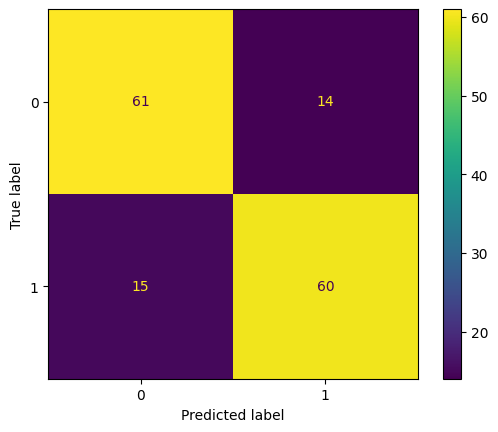

In [23]:
# Create confusion matrix list
disp_cm = list()

cm_gb_over = confusion_matrix(y_true = y_valid['oversampling'],
                            y_pred = y_valid_gb_pred_over)

disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_over,
                               display_labels=grad_tree_over.classes_)
disp_cm.append(disp_1)

disp_1.plot()
plt.show()

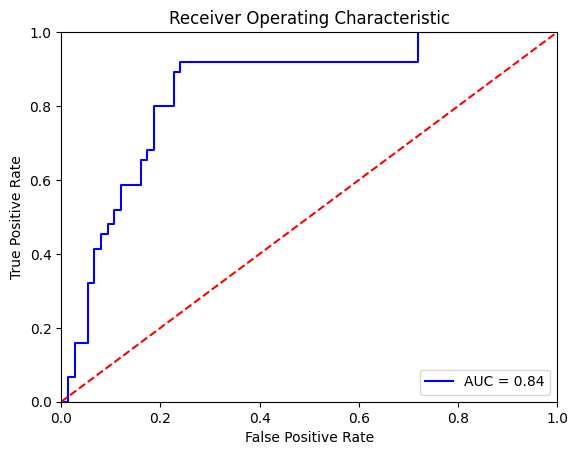

In [24]:
y_valid_gb_pred_over_proba = grad_tree_over.predict_proba(x_valid['oversampling'])

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC = %0.2f' % roc_auc_gb_over)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### <a id='toc4_1_2_'></a>[Smote](#toc0_)
----

In [25]:
# n_estimators = [1,5,10,30,50,70,100,150,200,250]
# max_depth = np.arange(2,11,1)
# learning_rate = np.arange(0.1,1,0.1)

# param_grid = {
#         "n_estimators": n_estimators,
#         "learning_rate" : learning_rate,
#         "max_depth" : max_depth
#         }

# # Buat gridsearch
# grad_tree = GradientBoostingClassifier()
# cv = StratifiedKFold(n_splits=5)


# grad_tree_cv_smote = BayesSearchCV(
#                         estimator = grad_tree,
#                         search_spaces= param_grid,
#                         cv = cv,
#                         scoring = "roc_auc",
#                         n_jobs = -1)

grad_tree_cv.fit(x_train["smote"], y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=GradientBoostingClassifier(random_state=123), n_jobs=-1,
              scoring='recall',
              search_spaces={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                             'n_estimators': [1, 5, 10, 30, 50, 70, 100, 150,
                                              200, 250]})

In [26]:
# Manual Hyperparameter Tuning
# grad_tree_smote = GradientBoostingClassifier(
#                                     max_depth = 7,
#                                     n_estimators = 30,
#                                     learning_rate = 0.2,
                                    # random_state=123)

grad_tree_smote = GradientBoostingClassifier(
                                    max_depth = grad_tree_cv.best_params_['max_depth'],
                                    n_estimators = grad_tree_cv.best_params_['n_estimators'],
                                    learning_rate = grad_tree_cv.best_params_['learning_rate'],
                                    random_state=123)

grad_tree_smote.fit(x_train["smote"], y_train["smote"])

GradientBoostingClassifier(learning_rate=0.2, n_estimators=5, random_state=123)

In [27]:
## Classification Report
y_valid_gb_pred_smote = grad_tree_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_gb_pred_smote))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        75
           1       0.82      0.97      0.89        75

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



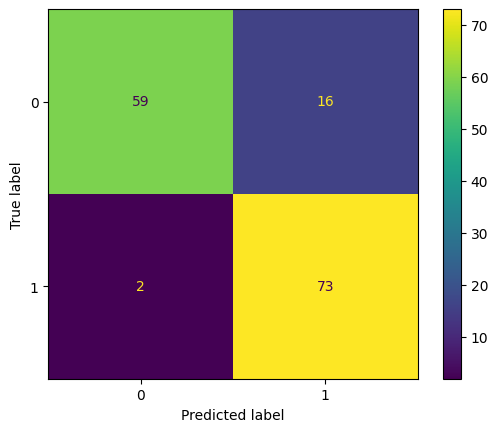

In [28]:
cm_gb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_gb_pred_smote)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_smote,
                               display_labels=grad_tree_smote.classes_)

disp_cm.append(disp_2)

disp_2.plot()
plt.show()

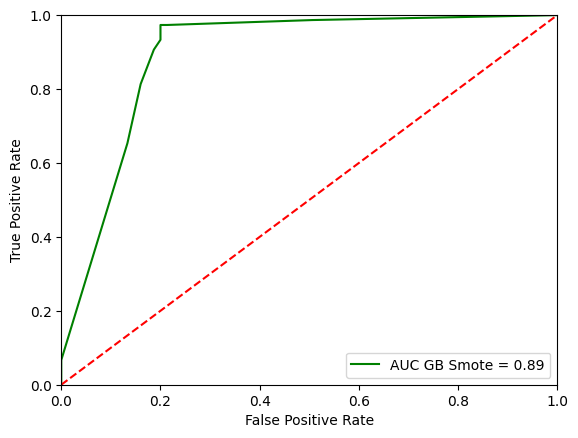

In [29]:
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])
fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)

plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_gb_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### <a id='toc4_1_3_'></a>[ROC Curve Gradient Boosting on SMOTE and Oversampling](#toc0_)
---------

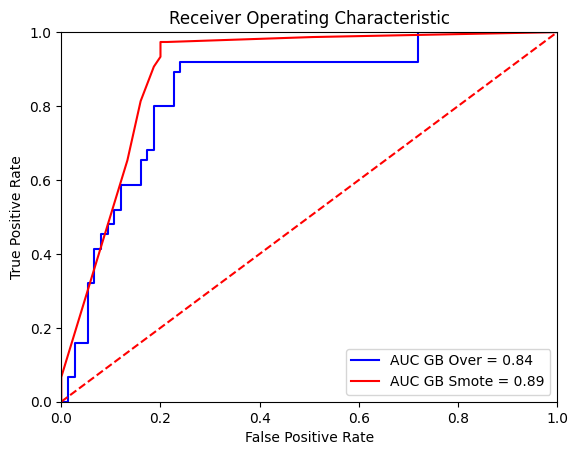

In [30]:
y_valid_gb_pred_over_proba = grad_tree_over.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GB Over = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'r', label = 'AUC GB Smote = %0.2f' % roc_auc_gb_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
# util.pickle_dump(grad_tree, config_data['model_params_path'][4])

## <a id='toc4_2_'></a>[Random Forest](#toc0_)

### <a id='toc4_2_1_'></a>[Smote](#toc0_)
---------

In [32]:
criterion = ['entropy']
n_estimators = [10,50,100,150,200,250,300]

param_grid = {
        "criterion": criterion,
        "n_estimators" : n_estimators
        }

# Buat gridsearch
rf_tree = RandomForestClassifier(random_state=123)
cv = StratifiedKFold(n_splits=5)


rf_tree_cv_smote = BayesSearchCV(
                        estimator = rf_tree,
                        search_spaces= param_grid,
                        cv = cv,
                        scoring = "roc_auc",
                        n_jobs = -1)

rf_tree_cv_smote.fit(x_train["smote"], y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
              scoring='roc_auc',
              search_spaces={'criterion': ['entropy'],
                             'n_estimators': [10, 50, 100, 150, 200, 250, 300]})

In [33]:
# Manual Hyperparameter Tuning
# rf_tree_smote = RandomForestClassifier(
#                                     criterion='entropy',
#                                     n_estimators = 250,
#                                     random_state=123)

rf_tree_smote = RandomForestClassifier(
    n_estimators=rf_tree_cv_smote.best_params_['n_estimators'],
    criterion=rf_tree_cv_smote.best_params_['criterion'],
    random_state=123
)

rf_tree_smote.fit(x_train["smote"], y_train["smote"])

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=123)

In [34]:
## Classification Report
y_valid_rf_pred_smote = rf_tree_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_rf_pred_smote))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        75
           1       0.83      0.92      0.87        75

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



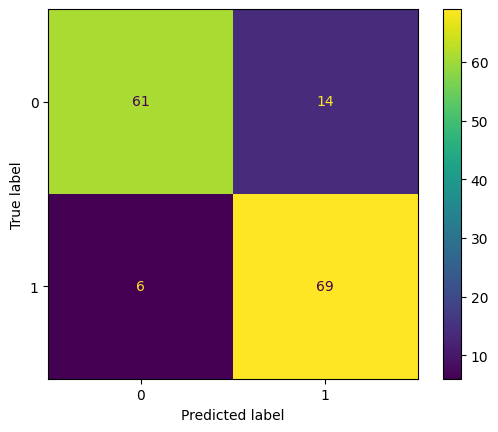

In [35]:
rf_gb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_rf_pred_smote)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=rf_gb_smote,
                               display_labels=rf_tree_smote.classes_)

disp_cm.append(disp_2)

disp_2.plot()
plt.show()

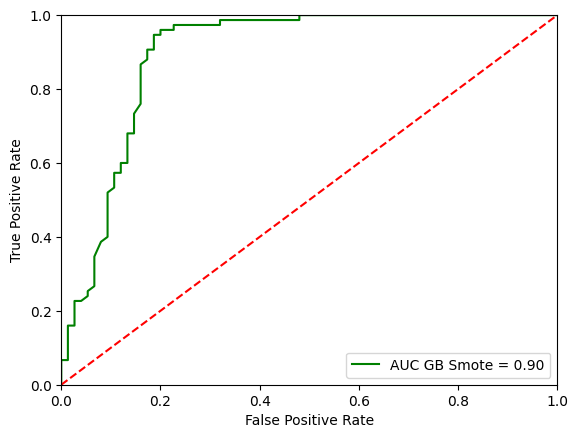

In [36]:
y_valid_rf_pred_smote_proba = rf_tree_smote.predict_proba(x_valid['smote'])

fpr_fr_smote, tpr_fr_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_rf_pred_smote_proba[:, 1])

roc_auc_rf_smote = auc(fpr_fr_smote, tpr_fr_smote)

plt.plot(fpr_fr_smote, tpr_fr_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_rf_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc4_3_'></a>[XGBOOST Classifier](#toc0_)

### <a id='toc4_3_1_'></a>[Smote](#toc0_)
------

In [37]:
n_estimators = [1,7,10,30,50,100,150,200,250,300]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)
scale_pos_weight = np.arange(0.1,0.5,0.1)
alpha = np.arange(1,6,1)

xgb = XGBClassifier(random_state=123)

dist_params_xgb1 = {
        "n_estimators" : n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        "scale_pos_weight" : scale_pos_weight,
        "gamma" : alpha,
        "random_state" : [123]
    }

xgb_cv = BayesSearchCV(
                    estimator=xgb,
                    search_spaces=dist_params_xgb1,
                    cv = cv,
                    scoring = 'recall',
                    n_jobs = -1,
                    )

xgb_cv.fit(x_train["smote"], y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance...
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=123, ...),
              n_jobs=-1, scoring='recall',
              search_spaces={'gamma': array([1, 2, 3, 4, 5]),
                             'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                             'n_estimators': [1, 7, 10, 30, 50, 100, 150, 200,
                                              250, 300],
                             'random_state': [123],
                             'scale_pos_weight': array([0.1, 0.2, 0.3, 0.4])})

In [38]:
xgb_cv.best_params_

OrderedDict([('gamma', 5),
             ('learning_rate', 0.30000000000000004),
             ('max_depth', 3),
             ('n_estimators', 7),
             ('random_state', 123),
             ('scale_pos_weight', 0.4)])

In [39]:
# xgb_smote = XGBClassifier(
#                     n_estimators = 7,
#                     learning_rate = 0.7,
#                     max_depth = 4,
#                     scale_pos_weight = 0.4,
#                     alpha = 5,
#                     random_state=123)

xgb_smote = XGBClassifier(
    n_estimators = xgb_cv.best_params_['n_estimators'],
    learning_rate = xgb_cv.best_params_['learning_rate'],
    max_depth = xgb_cv.best_params_['max_depth'],
    scale_pos_weight = xgb_cv.best_params_['scale_pos_weight'],
    gamma = xgb_cv.best_params_['gamma'],
    random_state = 123
)



xgb_smote.fit(x_train["smote"], y_train["smote"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30000000000000004,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [40]:
y_valid_xgb_pred_smote = xgb_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_xgb_pred_smote))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86        75
           1       0.83      0.95      0.88        75

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



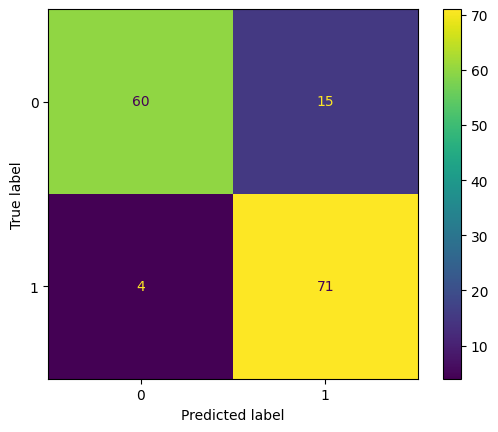

In [41]:
cm_xgb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_xgb_pred_smote)

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_smote,
                               display_labels=xgb_smote.classes_)
disp_cm.append(disp_3)

disp_3.plot()
plt.show()

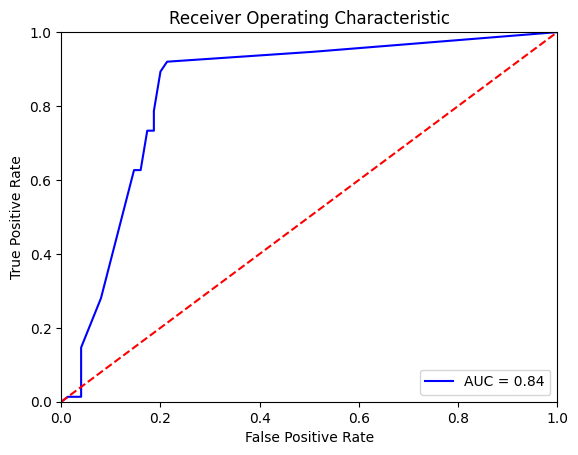

In [42]:
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_valid['oversampling'])

fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_valid['oversampling'],
                                         y_valid_xgb_smote_proba[:, 1])
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'b', label = 'AUC = %0.2f' % roc_auc_xgb_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

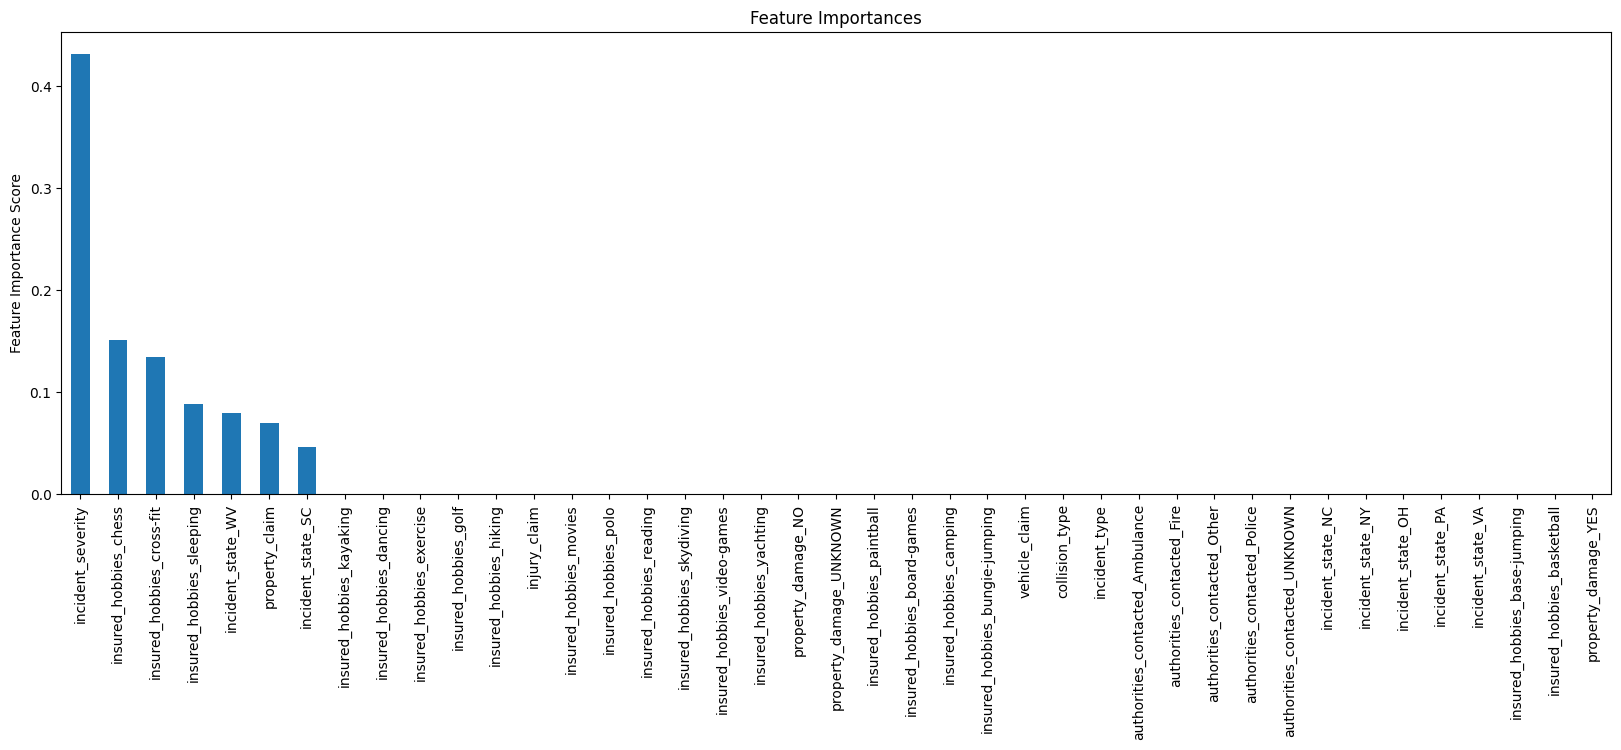

In [43]:
fig, ax = plt.subplots(figsize=(20,6))

feat_imp = pd.Series(xgb_smote.feature_importances_, x_valid['smote'].columns.to_list()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

### <a id='toc4_3_2_'></a>[Oversampling](#toc0_)
-----

In [44]:
# n_estimators = [1,7,10,30,50,100,150,200,250,300]
# max_depth = np.arange(2,11,1)
# learning_rate = np.arange(0.1,1,0.1)
# scale_pos_weight = np.arange(0.1,0.5,0.1)
# gamma = np.arange(1,6,1)

# xgb = XGBClassifier(random_state=123)

# dist_params_xgb1 = {
#         "n_estimators" : n_estimators,
#         "learning_rate" : learning_rate,
#         "max_depth" : max_depth,
#         "scale_pos_weight" : scale_pos_weight,
#         "gamma" : gamma,
#         "random_state" : [123]
#     }

# xgb_cv = BayesSearchCV(
#                     estimator=xgb,
#                     search_spaces=dist_params_xgb1,
#                     cv = cv,
#                     scoring = 'roc_auc',
#                     n_jobs = -1,
#                     )

xgb_cv.fit(x_train["smote"], y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance...
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=123, ...),
              n_jobs=-1, scoring='recall',
              search_spaces={'gamma': array([1, 2, 3, 4, 5]),
                             'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                             'n_estimators': [1, 7, 10, 30, 50, 100, 150, 200,
                                              250, 300],
                             'random_state': [123],
                             'scale_pos_weight': array([0.1, 0.2, 0.3, 0.4])})

In [45]:
# xgb_over = XGBClassifier(
#                     n_estimators = 7,
#                     learning_rate = 0.7,
#                     max_depth = 4,
#                     scale_pos_weight = 0.4,
#                     alpha = 5,
#                     random_state=123)

xgb_over = XGBClassifier(
                    n_estimators = xgb_cv.best_params_['n_estimators'],
                    learning_rate = xgb_cv.best_params_['learning_rate'],
                    max_depth = xgb_cv.best_params_['max_depth'],
                    scale_pos_weight = xgb_cv.best_params_['scale_pos_weight'],
                    gamma = xgb_cv.best_params_['gamma'],
                    random_state=123)

xgb_over.fit(x_train["oversampling"], y_train["oversampling"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [46]:
y_valid_xgb_pred_over = xgb_over.predict(x_valid['oversampling'])

print(classification_report(y_true = y_valid['oversampling'],
                            y_pred = y_valid_xgb_pred_over))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        75
           1       0.82      0.92      0.87        75

    accuracy                           0.86       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150



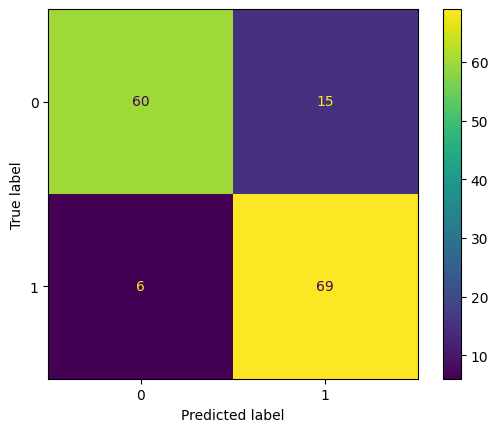

In [47]:
cm_xgb_over = confusion_matrix(y_true = y_valid['oversampling'],
                            y_pred = y_valid_xgb_pred_over)

disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_over,
                               display_labels=xgb_over.classes_)

disp_cm.append(disp_4)
disp_4.plot()
plt.show()

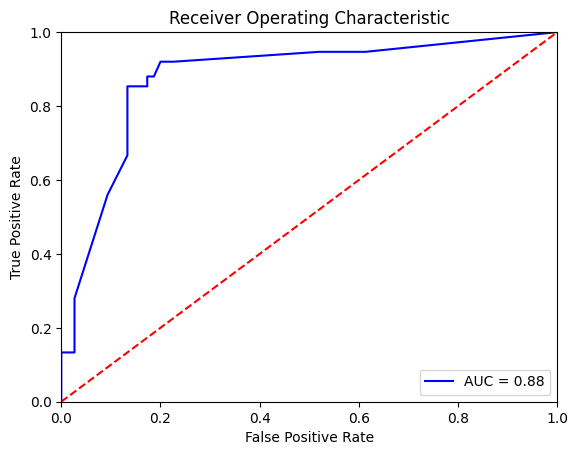

In [48]:
y_valid_xgb_smote_proba = xgb_over.predict_proba(x_valid['oversampling'])

fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_valid['oversampling'],
                                         y_valid_xgb_smote_proba[:, 1])
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'b', label = 'AUC = %0.2f' % roc_auc_xgb_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:
# util.pickle_dump(xgb, config_data['model_params_path'][6])

## <a id='toc4_4_'></a>[Decision Tree](#toc0_)

### <a id='toc4_4_1_'></a>[Smote](#toc0_)

In [51]:

max_depth = np.arange(2,11,1)
criterion =['gini','entropy']
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "criterion" : criterion,
        "max_depth" : max_depth,
        }

# Buat gridsearch
dt_tree = DecisionTreeClassifier(random_state=123)
cv = StratifiedKFold(n_splits=5)

dt_tree_cv = BayesSearchCV(
                        estimator = dt_tree,
                        search_spaces = param_grid,
                        cv = cv,
                        scoring = "recall",
                        n_jobs = -1)

dt_tree_cv.fit(x_train["smote"],y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=DecisionTreeClassifier(random_state=123), n_jobs=-1,
              scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [60]:
dt_tree_cv.best_params_

OrderedDict([('criterion', 'gini'), ('max_depth', 4)])

In [53]:
dt_tree = DecisionTreeClassifier(
    max_depth = dt_tree_cv.best_params_['max_depth'],
    criterion = dt_tree_cv.best_params_['criterion'],
    random_state=123
)

dt_tree.fit(x_train["smote"], y_train["smote"])

y_dt_pred = dt_tree.predict(x_train["smote"])

accuracy_score(y_true=y_train["smote"],
               y_pred=y_dt_pred)

0.9011627906976745

In [55]:
y_valid_dt_smote = dt_tree.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_dt_smote))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        75
           1       0.82      0.97      0.89        75

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



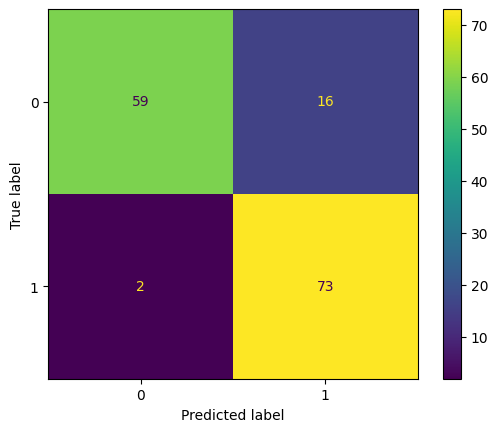

In [57]:
cm_dt = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_dt_smote)

disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                               display_labels=dt_tree.classes_)

disp_cm.append(disp_5)
disp_5.plot()
plt.show()

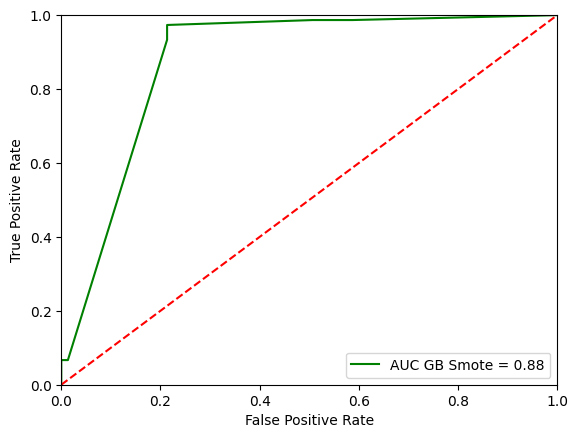

In [58]:
y_valid_dt_tree_proba = dt_tree.predict_proba(x_valid['smote'])

fpr_dt_smote, tpr_dt_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_dt_tree_proba[:, 1])

roc_auc_dt_smote = auc(fpr_dt_smote, tpr_dt_smote)

plt.plot(fpr_dt_smote, tpr_dt_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_dt_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc4_5_'></a>[ADABOOST](#toc0_)

### <a id='toc4_5_1_'></a>[Smote](#toc0_)
----------

In [65]:

n_estimators = [1,5,10,30,50,70,100,150,200,250]
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate
        }

# Buat gridsearch
ada = AdaBoostClassifier(random_state=123)
cv = StratifiedKFold(n_splits=5)

ada_cv = BayesSearchCV(
                        estimator = ada,
                        search_spaces = param_grid,
                        cv = cv,
                        scoring = "recall",
                        n_jobs = -1)

ada_cv.fit(x_train["smote"],y_train["smote"])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=AdaBoostClassifier(random_state=123), n_jobs=-1,
              scoring='recall',
              search_spaces={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                             'n_estimators': [1, 5, 10, 30, 50, 70, 100, 150,
                                              200, 250]})

In [71]:
ada_smote = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=2),
    n_estimators = ada_cv.best_params_['n_estimators'],
    learning_rate = ada_cv.best_params_['learning_rate'],
    random_state = 123
)

ada_smote.fit(x_train['smote'], y_train['smote'])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=70, random_state=123)

In [72]:
y_valid_ada_smote = ada_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_ada_smote))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        75
           1       0.82      0.97      0.89        75

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



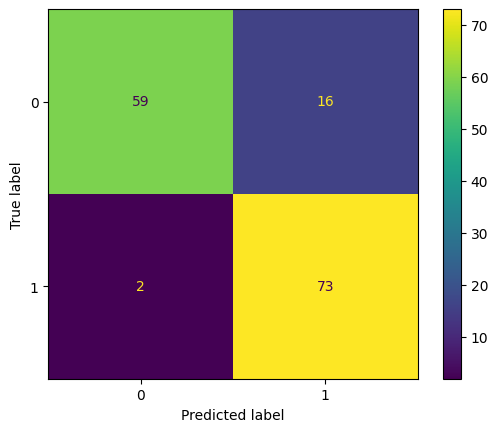

In [73]:
cm_ada = confusion_matrix(y_true = y_valid['smote'],
                      y_pred = y_valid_ada_smote)

disp_6 = ConfusionMatrixDisplay(confusion_matrix=cm_ada,
                               display_labels=ada_smote.classes_)

disp_cm.append(disp_6)
disp_6.plot()
plt.show()

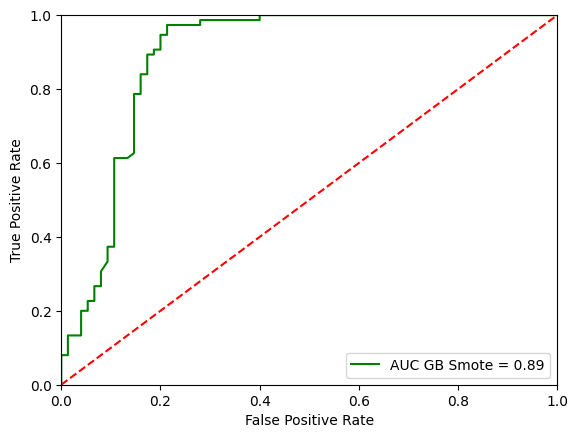

In [74]:
y_valid_ada_smote_proba = ada_smote.predict_proba(x_valid['smote'])
fpr_ada_smote, tpr_ada_smote, _ = roc_curve(y_valid['smote'],
                                                y_valid_ada_smote_proba[:, 1])

roc_auc_ada_smote = auc(fpr_ada_smote, tpr_ada_smote)
plt.plot(fpr_ada_smote, tpr_ada_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_ada_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc4_6_'></a>[<b>ROC Plot (Auc Score)</b>](#toc0_)
---------

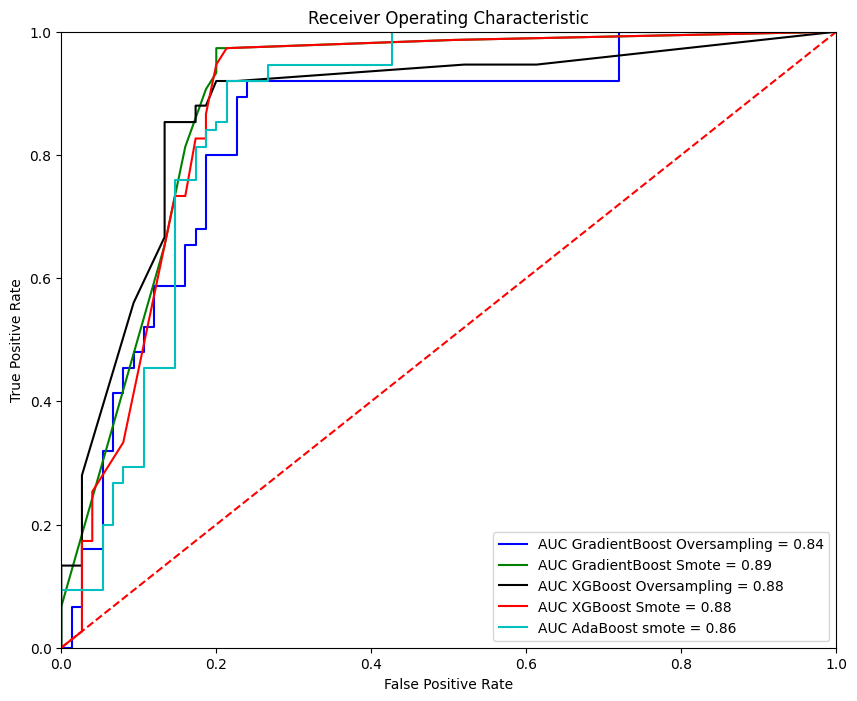

In [76]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_valid['oversampling'])
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_valid['smote'])
y_valid_ada_smote_proba = ada_smote.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_over_proba = grad_tree_over.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, _ = roc_curve(y_valid['oversampling'],
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_xgb_smote_proba[:, 1])
fpr_ada_smote, tpr_ada_smote, _ = roc_curve(y_valid['smote'],
                                                           y_valid_ada_smote_proba[:, 1])
fpr_gb_over, tpr_gb_over, _ = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_ada_smote = auc(fpr_ada_smote, tpr_ada_smote)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_ada_smote, tpr_ada_smote, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# <a id='toc5_'></a>[<b> Hyperparameter Tuning</b>](#toc0_)

## <a id='toc5_1_'></a>[Create Param Distribution](#toc0_)
---

In [98]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres   

    dist_params_xgb = {
        "n_estimators" : [xgb_cv.best_params_['n_estimators']],
        "learning_rate" : [xgb_cv.best_params_['learning_rate']],
        "max_depth" : [xgb_cv.best_params_['max_depth']],
        "gamma" : [xgb_cv.best_params_['gamma']],
        "scale_pos_weight" : [xgb_cv.best_params_['scale_pos_weight']],
    }

    dist_params_gb = {
        "max_depth" : [grad_tree_cv.best_params_['max_depth']],
        "n_estimators" : [grad_tree_cv.best_params_['n_estimators']],
        "learning_rate" : [grad_tree_cv.best_params_['learning_rate']],
    }
    
    dist_params_ada = {
        "base_estimator" : [DecisionTreeClassifier(max_depth = 2)],
        "n_estimators" : [ada_cv.best_params_['n_estimators']],
        "learning_rate" : [ada_cv.best_params_['learning_rate']],
    }

    dist_params_dt = {
        "max_depth" : [dt_tree_cv.best_params_['max_depth']],
        "criterion" : [dt_tree_cv.best_params_['criterion']]
    }

    dist_params_rf = {
        "n_estimators": [rf_tree_cv_smote.best_params_['n_estimators']],
        "criterion": [rf_tree_cv_smote.best_params_['criterion']],
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "GradientBoostingClassifier": dist_params_gb,
        "AdaBoostClassifier": dist_params_ada,
        "DecisionTreeClassifier": dist_params_dt,
        "RandomForestClassifier":dist_params_rf
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [99]:
def hyper_params_tuning(model: list) -> list:
    # Create copy of current best baseline model
    model_list = []
    trained_model = [XGBClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),DecisionTreeClassifier(),RandomForestClassifier()]
    
    # Create model object
    for col, mod in list(zip(model, trained_model)):
        dist_params = create_dist_params(col)
        model_rsc = BayesSearchCV(mod, dist_params, n_jobs = -1)
        model_ = {
                        "model_name": col,
                        "model_object": model_rsc,
                        "model_uid": ""
                    }
            
        model_list.append(model_.copy())
    
    # Return model object
    return model_list

## <a id='toc5_1_1_'></a>[run debugging](#toc0_)

In [103]:
listmodel_ = hyper_params_tuning(['XGBClassifier',
                                  'GradientBoostingClassifier', 
                                  'AdaBoostClassifier',
                                  'DecisionTreeClassifier',
                                  'RandomForestClassifier'])

listmodel_

[{'model_name': 'XGBClassifier',
  'model_object': BayesSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_...
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_s

    Copy list of trained model

In [81]:
list__model = copy.deepcopy(list_of_trained_model)

    Update list of trained model with hyperparams model

In [84]:
for config in list__model:
    for l in (listmodel_[0], listmodel_[1], listmodel_[2], listmodel_[3], listmodel_[4]):
        list__model[config].append(l)

In [86]:
for model in list__model['nonbalance']:
    print(model['model_name'])

DecisionTreeClassifier
LogisticRegression
SVC
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
QuadraticDiscriminantAnalysis
GaussianNB
XGBClassifier
GradientBoostingClassifier
AdaBoostClassifier
DecisionTreeClassifier
RandomForestClassifier


    Check the parameter distribution we added into list__model

In [87]:
list__model['nonbalance'][-5:]

[{'model_name': 'XGBClassifier',
  'model_object': GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False, eval_metric=None,
                                       feature_types=None, gamma=None,
                                       gpu_id=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_b...
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max

## <b> Run Hyperparamater Model </b>

<b><mark>!! Be Aware this function takes long times to finish </b><mark>

In [94]:
def train_eval_hyper(configuration_model: str, params: dict, hyperparams_model: list = None, log_path: str = None):

    # Variable to store trained models
    list_of_trained_model = dict()

    # Create training log template
    training_log = training_log_template()

    for config in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config))

        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            ## list of hyperparams is three models behind (look list__model[config])
            list_of_model = copy.deepcopy(hyperparams_model[config][-3:])

        # Variable to store trained model
        trained_model = list()

        x_train_data = x_train[config]
        y_train_data = y_train[config]
        x_valid_data = x_valid[config]
        y_valid_data = y_valid[config]

        # Train each model by current dataset
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evaluating model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid_data)
            performance = classification_report(y_valid_data, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["f1-score"])
            training_log["recall_score"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collenct current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug Message
            util.print_debug("Model {} has been trained".format(model["model_name"]))

        # Collect current trained list of model
        list_of_trained_model[config] = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models and data has been trained.")

    if log_path == None:
        training_log_ = training_log
    else:
        training_log_ = training_log_updater(training_log, log_path)

    return list_of_trained_model, training_log_

In [102]:
list_of_hyperparam_model, training_log_ = train_eval_hyper("hyperparam", 
                                                           config_data, 
                                                           list__model, 
                                                           config_data['training_log_path'])

2023-08-31 07:50:55.746885 creating training log template.
2023-08-31 07:50:55.746885 Training log template created.
2023-08-31 07:50:55.746885 Training model based on configuration data: nonbalance
2023-08-31 07:50:55.746885 Training model: AdaBoostClassifier


TypeError: Parameter grid for parameter 'n_estimators' needs to be a list or a numpy array, but got 70 (of type int) instead. Single values need to be wrapped in a list with one element.

## <a id='toc5_2_'></a>[Create Training Function based on Validation](#toc0_)
----

In [90]:
def train_eval_valid(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    # x_train, y_train, \
    # x_valid, y_valid, \
    # x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <a id='toc5_3_'></a>[Training model and update Training Logs](#toc0_)
---

In [73]:
list_of_trained_model_valid, \
training_log_valid = train_eval_valid("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:15:31.071627 creating training log template.
2023-01-07 22:15:31.071627 Training log template created.
2023-01-07 22:15:31.071627 Training model based on configuration data: nonbalance
2023-01-07 22:15:31.073625 Training model: XGBClassifier
2023-01-07 22:15:31.917829 Evalutaing model: XGBClassifier
2023-01-07 22:15:31.964822 Logging: XGBClassifier
2023-01-07 22:15:31.974823 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:31.974823 Training model: GradientBoostingClassifier
2023-01-07 22:15:32.217328 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:15:32.237357 Logging: GradientBoostingClassifier
2023-01-07 22:15:32.244982 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:32.244982 Training model: AdaBoostClassifier
2023-01-07 22:15:32.498412 Evalutaing model: AdaBoostClassifier
2023-01-07 22:15:32.547412 Logging: AdaBoostClassifier
2023-01-07 22:15:32.553410 Model AdaBo

## <a id='toc5_4_'></a>[Best Model Overview](#toc0_)
----

In [91]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_valid)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
4,Hyperparams-smote-XGBClassifier,0.952034,"{'0': {'precision': 0.8717948717948718, 'recall': 0.9066666666666666, 'f1-score': 0.8888888888888887, 'support': 75}, '1': {'precision': 0.6818181818181818, 'recall': 0.6, 'f1-score': 0.6382978723404256, 'support': 25}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7768065268065267, 'recall': 0.7533333333333333, 'f1-score': 0.7635933806146571, 'support': 100}, 'weighted avg': {'precision': 0.8243006993006994, 'recall': 0.83, 'f1-score': 0.826241134751773, 'support': 100}}",0.83
9,Hyperparams-oversampling-GradientBoostingClassifier,0.445997,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
10,Hyperparams-oversampling-AdaBoostClassifier,0.507705,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
6,Hyperparams-smote-AdaBoostClassifier,0.569004,"{'0': {'precision': 0.9384615384615385, 'recall': 0.8133333333333334, 'f1-score': 0.8714285714285714, 'support': 75}, '1': {'precision': 0.6, 'recall': 0.84, 'f1-score': 0.7000000000000001, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7692307692307692, 'recall': 0.8266666666666667, 'f1-score': 0.7857142857142858, 'support': 100}, 'weighted avg': {'precision': 0.8538461538461539, 'recall': 0.82, 'f1-score': 0.8285714285714286, 'support': 100}}",0.82
2,Hyperparams-nonbalance-AdaBoostClassifier,0.252431,"{'0': {'precision': 0.9242424242424242, 'recall': 0.8133333333333334, 'f1-score': 0.8652482269503545, 'support': 75}, '1': {'precision': 0.5882352941176471, 'recall': 0.8, 'f1-score': 0.6779661016949153, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7562388591800356, 'recall': 0.8066666666666666, 'f1-score': 0.771607164322635, 'support': 100}, 'weighted avg': {'precision': 0.8402406417112299, 'recall': 0.81, 'f1-score': 0.8184276956364946, 'support': 100}}",0.81
5,Hyperparams-smote-GradientBoostingClassifier,0.633001,"{'0': {'precision': 0.9375, 'recall': 0.8, 'f1-score': 0.8633093525179856, 'support': 75}, '1': {'precision': 0.5833333333333334, 'recall': 0.84, 'f1-score': 0.6885245901639344, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7604166666666667, 'recall': 0.8200000000000001, 'f1-score': 0.7759169713409599, 'support': 100}, 'weighted avg': {'precision': 0.8489583333333333, 'recall': 0.81, 'f1-score': 0.8196131619294728, 'support': 100}}",0.81
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.170997,"{'0': {'precision': 0.8767123287671232, 'recall': 0.8533333333333334, 'f1-score': 0.8648648648648648, 'support': 75}, '1': {'precision': 0.5925925925925926, 'recall': 0.64, 'f1-score': 0.6153846153846153, 'support': 25}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7346524606798579, 'recall': 0.7466666666666667, 'f1-score': 0.74012474012474, 'support': 100}, 'weighted avg': {'precision': 0.8056823947234905, 'recall': 0.8, 'f1-score': 0.8024948024948024, 'support': 100}}",0.80
11,Hyperparams-oversampling-DecisionTreeClassifier,0.446059,"{'0': {'precision': 0.9365079365079365, 'recall': 0.7866666666666666, 'f1-score': 0.8550724637681159, 'support': 75}, '1': {'precision': 0.5675675675675675, 'recall': 0.84, 'f1-

# <a id='toc6_'></a>[<b>Test Data</b>](#toc0_)

## <a id='toc6_1_'></a>[Create ROC Curve toward Test Set](#toc0_)
----

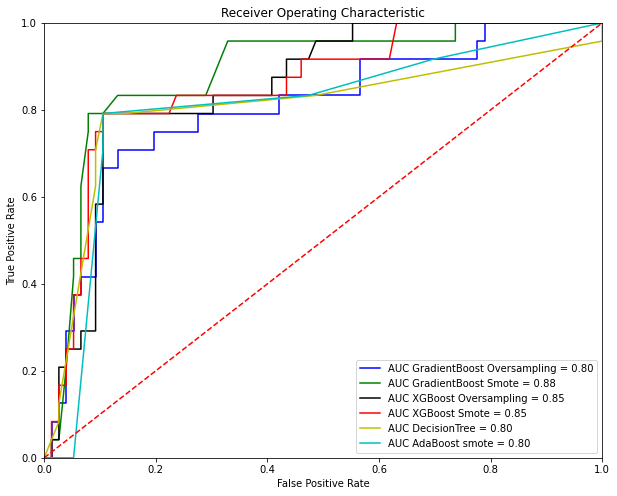

In [97]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_test)
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_test)
y_valid_dt_proba = dt_tree.predict_proba(x_test)
y_valid_ada_over_proba = ada_over.predict_proba(x_test)
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_test)
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_test)

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, threshold_xgb_over = roc_curve(y_test,
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_test,
                                         y_valid_xgb_smote_proba[:, 1])
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test,
                                        y_valid_dt_proba[:, 1])
fpr_ada_over, tpr_ada_over, threshold_ada_over = roc_curve(y_test,
                                                           y_valid_ada_over_proba[:, 1])
fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_test,
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_test,
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_ada_over = auc(fpr_ada_over, tpr_ada_over)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_dt, tpr_dt, 'y', label = 'AUC DecisionTree = %0.2f' % roc_auc_dt)
plt.plot(fpr_ada_over, tpr_ada_over, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_over)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc6_2_'></a>[Create Function to Eval Test Data](#toc0_)
----

In [63]:
def train_eval_test(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_test)
            performance = classification_report(y_test, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <a id='toc6_3_'></a>[Training Dataset and Update Training Logs](#toc0_)
---

In [75]:
list_of_trained_model_test, \
training_log_test = train_eval_test("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:16:01.574957 creating training log template.
2023-01-07 22:16:01.575956 Training log template created.
2023-01-07 22:16:01.575956 Training model based on configuration data: nonbalance
2023-01-07 22:16:01.577959 Training model: XGBClassifier
2023-01-07 22:16:02.180261 Evalutaing model: XGBClassifier
2023-01-07 22:16:02.232262 Logging: XGBClassifier
2023-01-07 22:16:02.244276 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.244276 Training model: GradientBoostingClassifier
2023-01-07 22:16:02.539229 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:16:02.562647 Logging: GradientBoostingClassifier
2023-01-07 22:16:02.569643 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.569643 Training model: AdaBoostClassifier
2023-01-07 22:16:02.815179 Evalutaing model: AdaBoostClassifier
2023-01-07 22:16:02.840880 Logging: AdaBoostClassifier
2023-01-07 22:16:02.844880 Model AdaBo

## <a id='toc6_4_'></a>[Check Best Model](#toc0_)
---

In [93]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_test)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

## <a id='toc6_5_'></a>[Save Production Model](#toc0_)
-----

In [106]:
model_test, \
production_model_log_test, \
training_logs_test = get_production_model(list_of_trained_model_test, 
                                          training_log_test, 
                                          config_data)

2023-01-07 23:21:23.121474 Choosing model by metrics score.
2023-01-07 23:21:23.121474 Converting training log type of data from dict to dataframe.
2023-01-07 23:21:23.128473 Trying to load previous production model.
2023-01-07 23:21:23.176474 Previous production model loaded.
2023-01-07 23:21:23.176474 Loading validation data.
2023-01-07 23:21:23.176474 Checking compatibilty previous production model's input with current train data's features.
2023-01-07 23:21:23.177473 Features compatible.
2023-01-07 23:21:23.177473 Reassesing previous model performance using current validation data.
2023-01-07 23:21:23.206476 Assessing complete.
2023-01-07 23:21:23.206476 Storing new metrics data to previous model structure.
2023-01-07 23:21:23.206476 Adding previous model data to current training log and list of model
2023-01-07 23:21:23.216478 Sorting training log by f1 macro avg and training time.
2023-01-07 23:21:23.221474 Searching model data based on sorted training log.
2023-01-07 23:21:23.25

# <a id='toc7_'></a>[<b>Show Best Final Model</b>](#toc0_)
----

In [107]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')

training_logs_test[["model_name","training_time","performance","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False)

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

In [108]:
model_test["model_data"]["model_object"]

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5], 'max_depth': [2],
                         'n_estimators': [5]})

# <a id='toc8_'></a>[<b> Check Production Model</b>](#toc0_)
---

In [178]:
check_model = util.pickle_load(config_data['production_model_path'])

In [179]:
check_model

{'model_data': {'model_name': 'GradientBoostingClassifier',
  'model_object': GradientBoostingClassifier(),
  'model_uid': '121a8caff5efea786a968ad0e31b1e5a'},
 'model_log': {'model_name': 'Production-GradientBoostingClassifier',
  'model_uid': '121a8caff5efea786a968ad0e31b1e5a',
  'training_time': 0.536438,
  'training_date': '2023-07-30 13:15:27.639259',
  'performance': {'0': {'precision': 0.9523809523809523,
    'recall': 0.8,
    'f1-score': 0.8695652173913043,
    'support': 75.0},
   '1': {'precision': 0.8275862068965517,
    'recall': 0.96,
    'f1-score': 0.888888888888889,
    'support': 75.0},
   'accuracy': 0.88,
   'macro avg': {'precision': 0.8899835796387521,
    'recall': 0.88,
    'f1-score': 0.8792270531400966,
    'support': 150.0},
   'weighted avg': {'precision': 0.8899835796387521,
    'recall': 0.88,
    'f1-score': 0.8792270531400966,
    'support': 150.0}},
  'f1_score_avg': 0.8792270531400966,
  'data_configurations': 'smote'}}